In [2]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import uproot
import os
import glob
import awkward as ak
from scipy.stats import norm
from matplotlib.ticker import MultipleLocator


In [3]:
setup_path ="/home/haue/repositories/Masters/setup/" 
data_path = "/home/haue/repositories/Masters/data/singleprotons/Al/inclbetacut/"
twop_path = "/home/haue/repositories/Masters/data/twoproton/Al/"
Al_files = glob.glob(os.path.join(data_path, "*mlio.root"))
twop_files = glob.glob(os.path.join(twop_path, "*mlio.root"))


frac = 0.9542011788469517 # (Na21/(p+Na21)) amount of energy the daughter nucleus gets of the total energy released in the decay
frac_err = 1.032071836027589e-10 # uncertainty of the fraction
psep = 5.50410 # proton separation energy of 22Mg
psep_err = 0.00016 # error of proton separation energy of 22Mg
bw = 0.01 # bin width to be used, 10 keV
scale = 3.326542500626603 # difference in solid angle coverage of two proton events up to 4pi
difference_in_method_error = 0.002 # 2 keV - error estimated from the choice of gauss fitting instead of peak finding using SearchHighRes()

In [4]:
E2 = np.array([]); fEdep = np.array([]); bEdep=np.array([])
for batch in uproot.iterate(Al_files, expressions=["E", "fEdep", "bEdep"],
                            cut="(id==3)"):
    E2=np.append(E2, ak.flatten(batch.E))
    fEdep=np.append(fEdep, ak.flatten(batch.fEdep))
    bEdep=np.append(bEdep, ak.flatten(batch.bEdep))
E2p = np.array([])
for batch in uproot.iterate(twop_files, expressions=["E"],
                            cut="(id==3)"):
    E2p=np.append(E2p, ak.flatten(batch.E))
bins = np.arange(1000, 9000+10, 10)
counts_E2, _ = np.histogram(E2, bins=bins)
counts_E2p, _ = np.histogram(E2p, bins=bins)

Es = counts_E2 - scale * counts_E2p
Es = np.maximum(Es, 0) 
E = np.repeat((bins[:-1] + 0.5 * (bins[1] - bins[0])),np.asarray(Es).astype(int))


In [5]:

def cal_error(energy):
    betacut=1000
    Elin = np.arange(0., 11000., 10.)
    sac = np.array([])
    SA = np.loadtxt("../twoproton/sam_21al_U4.dat")
    v, fEdepmax, Elow, Eupp, fEdeplow, Esplow = np.loadtxt("../twoproton/tdz_21al_U4.dat", unpack=True)
    for i in range(len(Elin)):
        val = 0.
        if Elin[i] < betacut:
    #            print(Elin[i])
            sac = np.append(sac, val)
        else:
                # do not include outermost strips
            for j in range(0+1, 16-1):
                for k in range(0+1, 16-1):
                    if Esplow[j*16 + k] < Elin[i] and Elin[i] < Eupp[j*16 + k]:
    #                         print(j, k, Elin[i])
                        pass
                    else:
                        val += SA[j, k]
            sac = np.append(sac, val)
    sac_ = 100*sac/(4*np.pi)
    sacmask = np.where(sac_<np.max(sac_))
    bad_E = Elin[sacmask]
    Emask = (bad_E>betacut)
    bad_E = bad_E[Emask]
    if energy>np.min(bad_E):
        raise ValueError(f"The energy in question falls within telescope deadzone no error correction to be deduced -> try energies above the zone: {np.max(bad_E)} using pcal_error(fEdep,bEdep)")
    hh = np.loadtxt("U4calerrors.dat") # first 16 entries are the errors from the front side strips in rising order and the last 16 are the backside strips in rising order
    front_err = hh[:len(hh)//2]
    back_err = hh[len(hh)//2:] 

    SA = np.loadtxt("../twoproton/sam_21al_U4.dat") # first entry is front strip 1 and is equal to zero next entry is front strip 2 
    
    cals = np.loadtxt(setup_path+"U4EE.cal")
    front_cal = cals[:len(hh)//2]
    back_cal = cals[len(hh)//2:]
    
    maxSA = np.max(SA)
    total_variance = 0
    counter = 0
    for i in range(16):
        for j in range(16):
            if i==0 or i==15 or j==0 or j==15:
                continue
            
            uncal_x = (2*energy - (front_cal[i][0]+back_cal[j][0])) / (front_cal[i][1]+back_cal[j][1])
            
            variance = (0.5 * front_err[i][0])**2 + \
                            (uncal_x/2 * front_err[i][1])**2 + \
                            (0.5 * back_err[j][0])**2 + \
                            (uncal_x/2 * back_err[j][1])**2 + \
                            (0.5 * uncal_x * front_err[i][2]) + \
                            (0.5 * uncal_x * back_err[j][2])
            weighted_variance = variance*(SA[i][j]/maxSA)
            total_variance += weighted_variance
            
            counter+=1
    
    return np.sqrt(total_variance/counter)/1e3





def pcal_error(fedep,bedep):
    betacut = 1000
    Elin = np.arange(0., 11000., 10.)
    sac = np.array([])
    SA = np.loadtxt("../twoproton/sam_21al_U4.dat")
    v, fEdepmax, Elow, Eupp, fEdeplow, Esplow = np.loadtxt("../twoproton/tdz_21al_U4.dat", unpack=True)
    for i in range(len(Elin)):
        val = 0.
        if Elin[i] < betacut:
    #            print(Elin[i])
            sac = np.append(sac, val)
        else:
                # do not include outermost strips
            for j in range(0+1, 16-1):
                for k in range(0+1, 16-1):
                    if Esplow[j*16 + k] < Elin[i] and Elin[i] < Eupp[j*16 + k]:
    #                         print(j, k, Elin[i])
                        pass
                    else:
                        val += SA[j, k]
            sac = np.append(sac, val)
    sac_ = 100*sac/(4*np.pi)
    sacmask = np.where(sac_<np.max(sac_))
    bad_E = Elin[sacmask]
    if fedep+bedep < np.min(bad_E)*0.95:
        #print(np.max(bad_E))
        raise ValueError(f"The energy in question falls below the telescope energy region -> try energies above the zone: {np.min(bad_E)} using pcal_error(fEdep,bEdep)")
    hh = np.loadtxt("U4calerrors.dat") # first 16 entries are the errors from the front side strips in rising order and the last 16 are the backside strips in rising order
    front_err = hh[:len(hh)//2]
    back_err = hh[len(hh)//2:] 

    SA = np.loadtxt("../twoproton/sam_21al_U4.dat") # first entry is front strip 1 and is equal to zero next entry is front strip 2 
    padcal_errs = np.loadtxt("P4calerrors.dat")
    padcal = np.loadtxt(setup_path+"P4mult.cal")
    cals = np.loadtxt(setup_path+"U4EE.cal")
    front_cal = cals[:len(hh)//2]
    back_cal = cals[len(hh)//2:]
    
    maxSA = np.max(SA)
    total_variance = 0
    counter = 0
    for i in range(16):
        for j in range(16):
            if i==0 or i==15 or j==0 or j==15:
                continue
            
            uncal_fedep = (2*fedep - (front_cal[i][0]+back_cal[j][0])) / (front_cal[i][1]+back_cal[j][1])
            
            variance = (0.5 * front_err[i][0])**2 + \
                            (uncal_fedep/2 * front_err[i][1])**2 + \
                            (0.5 * back_err[j][0])**2 + \
                            (uncal_fedep/2 * back_err[j][1])**2 + \
                            (0.5 * uncal_fedep * front_err[i][2]) + \
                            (0.5 * uncal_fedep * back_err[j][2])
            weighted_variance = variance*(SA[i][j]/maxSA)
            total_variance += weighted_variance
            
            counter+=1
    uncal_bedep = (bedep-padcal[0])/padcal[1]
    pad_var = (uncal_bedep**2 * padcal_errs[1]**2)+padcal_errs[0]**2
    return np.sqrt(total_variance/counter+pad_var)/1e3



def counter(ax,E, x_low, x_up, quiet=False):#, yscale='linear'):
    ys, xs = np.histogram(E/1e3, bins=np.arange(x_low,x_up+bw,bw))
    counts = np.sum(ys)
    counts_err = np.sqrt(np.sum(ys))
    if not quiet:
        #plt.figure(figsize=(8,5))
        #plt.hist(E/1e3, bins=np.arange(x_low-0.5,x_up+0.5+bw,bw), histtype='step', color='k', label="Full Data")
        ax.hist(E/1e3, bins=np.arange(x_low, x_up+bw,bw), histtype='step', color='r', label="Fit region")
        #plt.yscale(yscale)
        #plt.legend()
        #plt.xlabel("Energy(MeV)")
        #plt.ylabel("Counts/10keV")
        #plt.title(f"Counted region: {x_low}-{x_up}")
    return counts, counts_err


def draw_arrow_at_energy(ax, energy, counts, bins, label):
    energy_MeV = energy / 1e3
    bin_idx = np.searchsorted(bins, energy_MeV) - 1
    if bin_idx < 0 or bin_idx >= len(counts):
        raise ValueError(f"Energy {energy} keV is out of histogram range.")
    bin_width = bins[1] - bins[0]
    bin_left = bins[bin_idx]
    bin_right = bins[bin_idx + 1]
    relative_pos = (energy_MeV - bin_left) / bin_width
    if 0.25 < relative_pos < 0.75 or bin_idx == len(counts) - 1:
        max_count = counts[bin_idx]
        avg_energy = 0.5 * (bin_left + bin_right)
    else:
        if bin_idx + 1 >= len(counts):
            raise ValueError("Cannot average beyond last bin.")
        max_count = max(counts[bin_idx], counts[bin_idx + 1])
        avg_energy = 0.5 * (bins[bin_idx] + bins[bin_idx + 2])
    ax.annotate('', xy=(avg_energy, max_count + max_count*0.1), xytext=(avg_energy, max_count + max_count*0.2), arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->'))
    ax.text(avg_energy, max_count + max_count*0.25, label, ha='center', va='bottom', color='red', fontsize=12)
    return int(avg_energy * 1e3)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


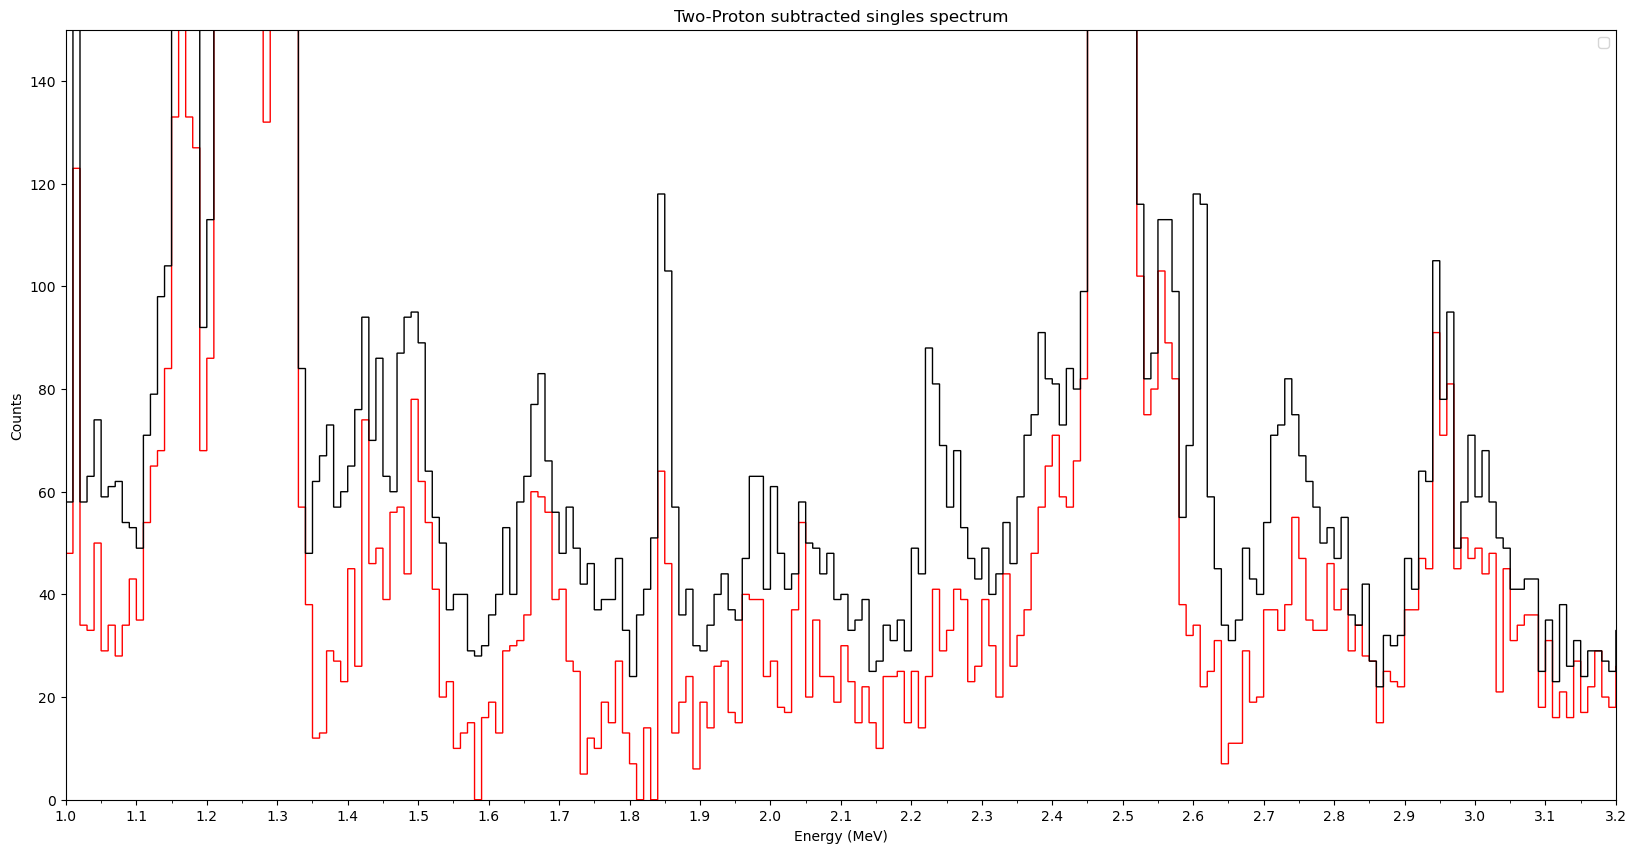

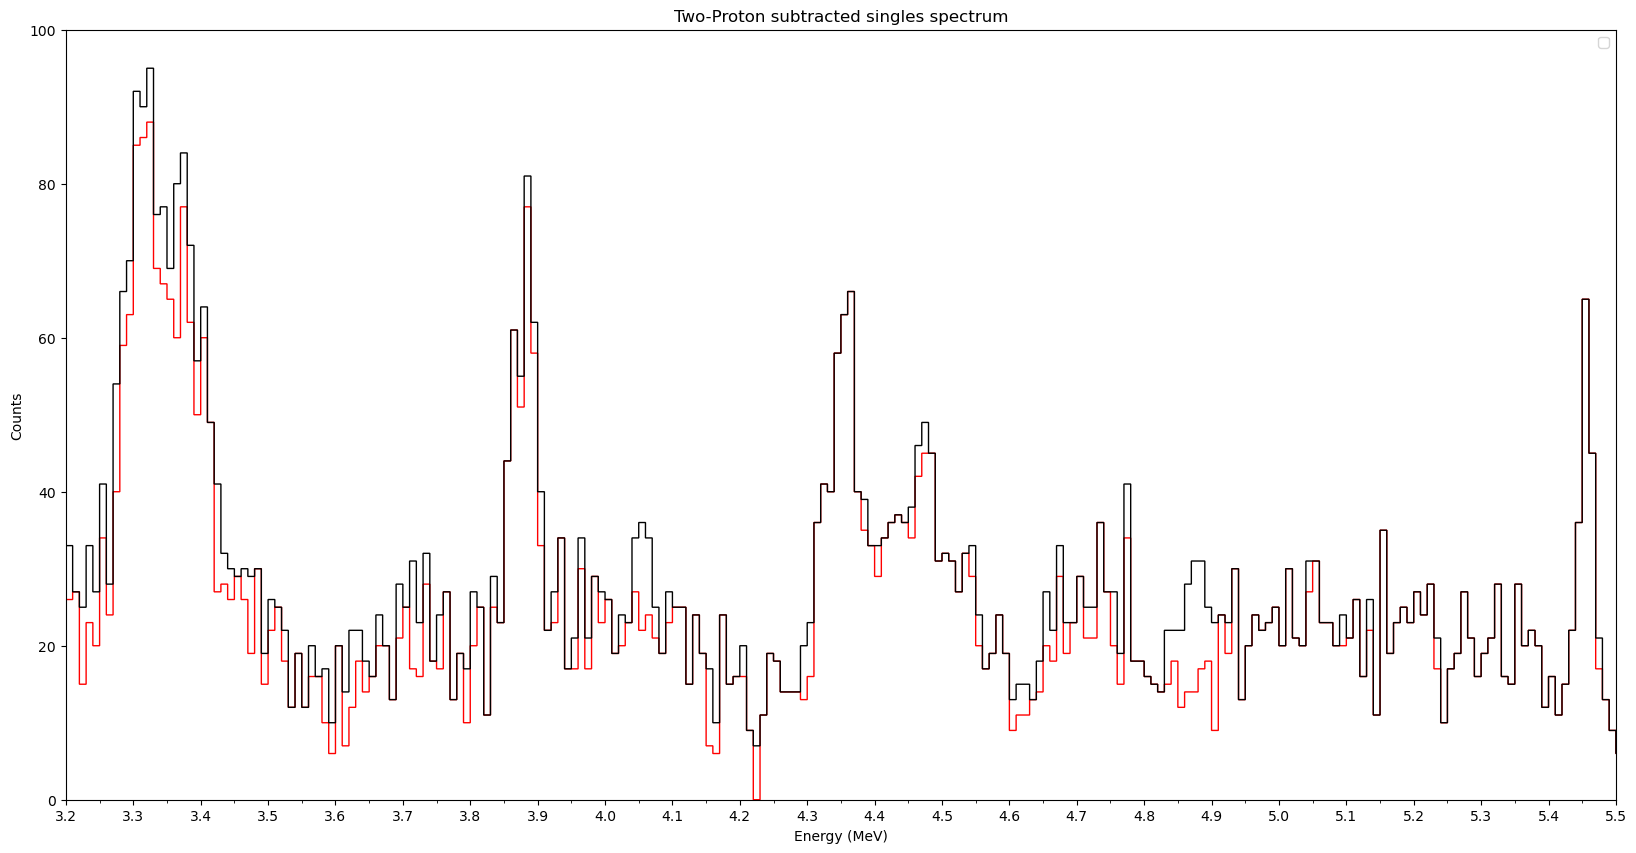

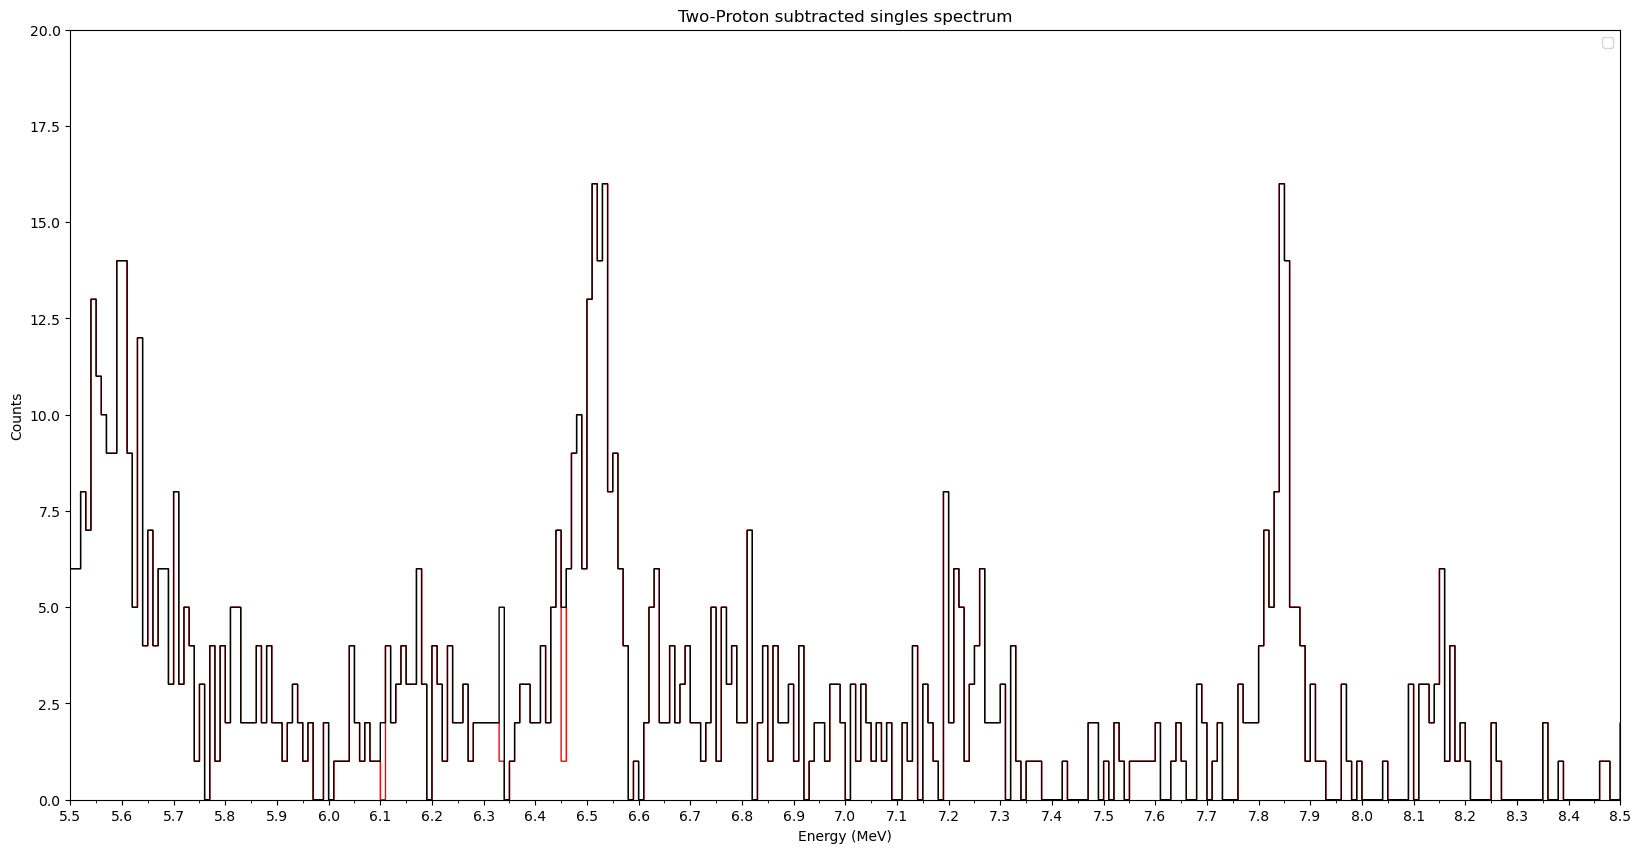

In [14]:

bins = np.arange(1, 9 + bw, bw)


plt.figure(figsize=(20,10))
plt.hist(E/1e3, bins=bins, histtype='step', color='r')
plt.hist(E2/1e3, bins=bins, histtype='step', color='k')

plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.title('Two-Proton subtracted singles spectrum')
plt.legend()
#plt.yscale('log')
plt.xlim(0.5,9)
plt.ylim(0,150)
plt.xlim(1,3.2)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
plt.savefig("1st.pdf")

plt.figure(figsize=(20,10))
plt.hist(E/1e3, bins=bins, histtype='step', color='r')
plt.hist(E2/1e3, bins=bins, histtype='step', color='k')

plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.title('Two-Proton subtracted singles spectrum')
plt.legend()
#plt.yscale('log')
plt.xlim(0.5,9)
plt.ylim(0,100)
plt.xlim(3.2,5.5)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
plt.savefig("2nd.pdf")


plt.figure(figsize=(20,10))
plt.hist(E/1e3, bins=bins, histtype='step', color='r')
plt.hist(E2/1e3, bins=bins, histtype='step', color='k')

plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.title('Two-Proton subtracted singles spectrum')
plt.legend()
#plt.yscale('log')
plt.xlim(0.5,9)
plt.ylim(0,20)
plt.xlim(5.5,8.5)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
plt.savefig("3rd.pdf")


TypeError: draw_arrow_at_energy() missing 1 required positional argument: 'label'

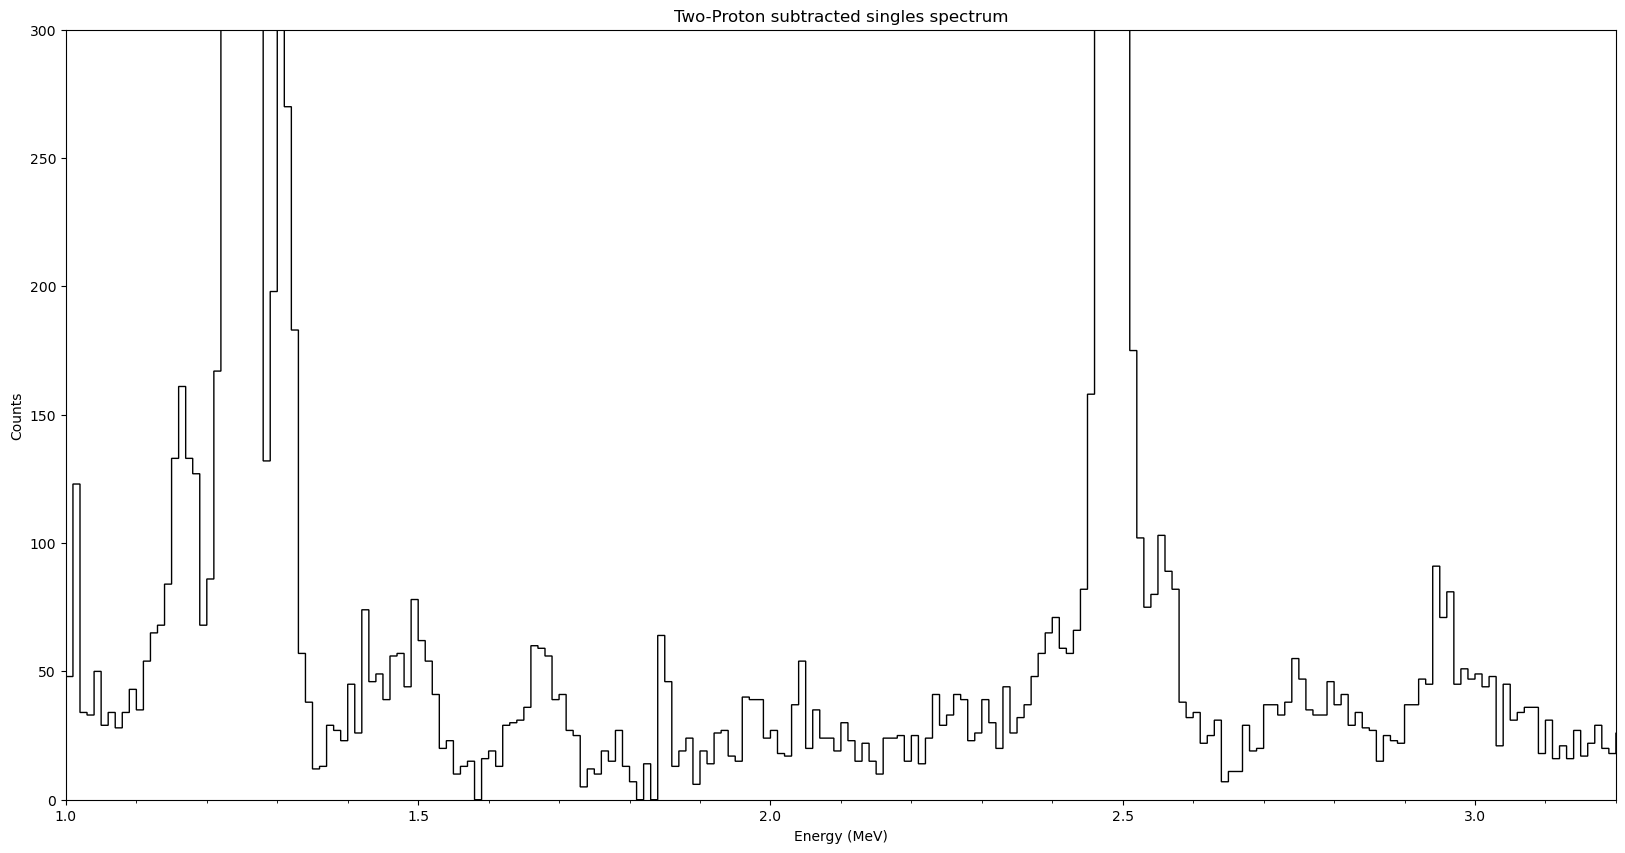

In [7]:
plt.figure(figsize=(20,10))
plt.hist(E/1e3, bins=bins, histtype='step', color='k')
#plt.hist(E2/1e3, bins=bins, histtype='step', color='k')
counts, _ = np.histogram(E/1e3, bins=bins)
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.title('Two-Proton subtracted singles spectrum')
#plt.legend()
#plt.yscale('log')
plt.xlim(0.5,9)
plt.ylim(0,300)
plt.xlim(1,3.2)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
one = draw_arrow_at_energy(ax, energy=1435, counts=counts, bins=bins)
two = draw_arrow_at_energy(ax, energy=1490, counts=counts, bins=bins)
three = draw_arrow_at_energy(ax, energy=1670, counts=counts, bins=bins)
four = draw_arrow_at_energy(ax, energy=1850, counts=counts, bins=bins)
five = draw_arrow_at_energy(ax, energy=1790, counts=counts, bins=bins)
six = draw_arrow_at_energy(ax, energy=1975, counts=counts, bins=bins)
eight = draw_arrow_at_energy(ax, energy=2250, counts=counts, bins=bins)
seven = draw_arrow_at_energy(ax, energy=2050, counts=counts, bins=bins)
nine = draw_arrow_at_energy(ax, energy=2750, counts=counts, bins=bins)
ten = draw_arrow_at_energy(ax, energy=2950, counts=counts, bins=bins)
eleven = draw_arrow_at_energy(ax, energy=3050, counts=counts, bins=bins)
#five = draw_arrow_at_energy(ax, energy=1975, counts=counts, bins=bins)
#six = draw_arrow_at_energy(ax, energy=2250, counts=counts, bins=bins)
one,two,three,four,five,six,seven,eight, nine,ten,eleven

(3310, 3380, 3890, 4350, 4430, 4470, 5450, 4590, 3450, 3990, 4120)

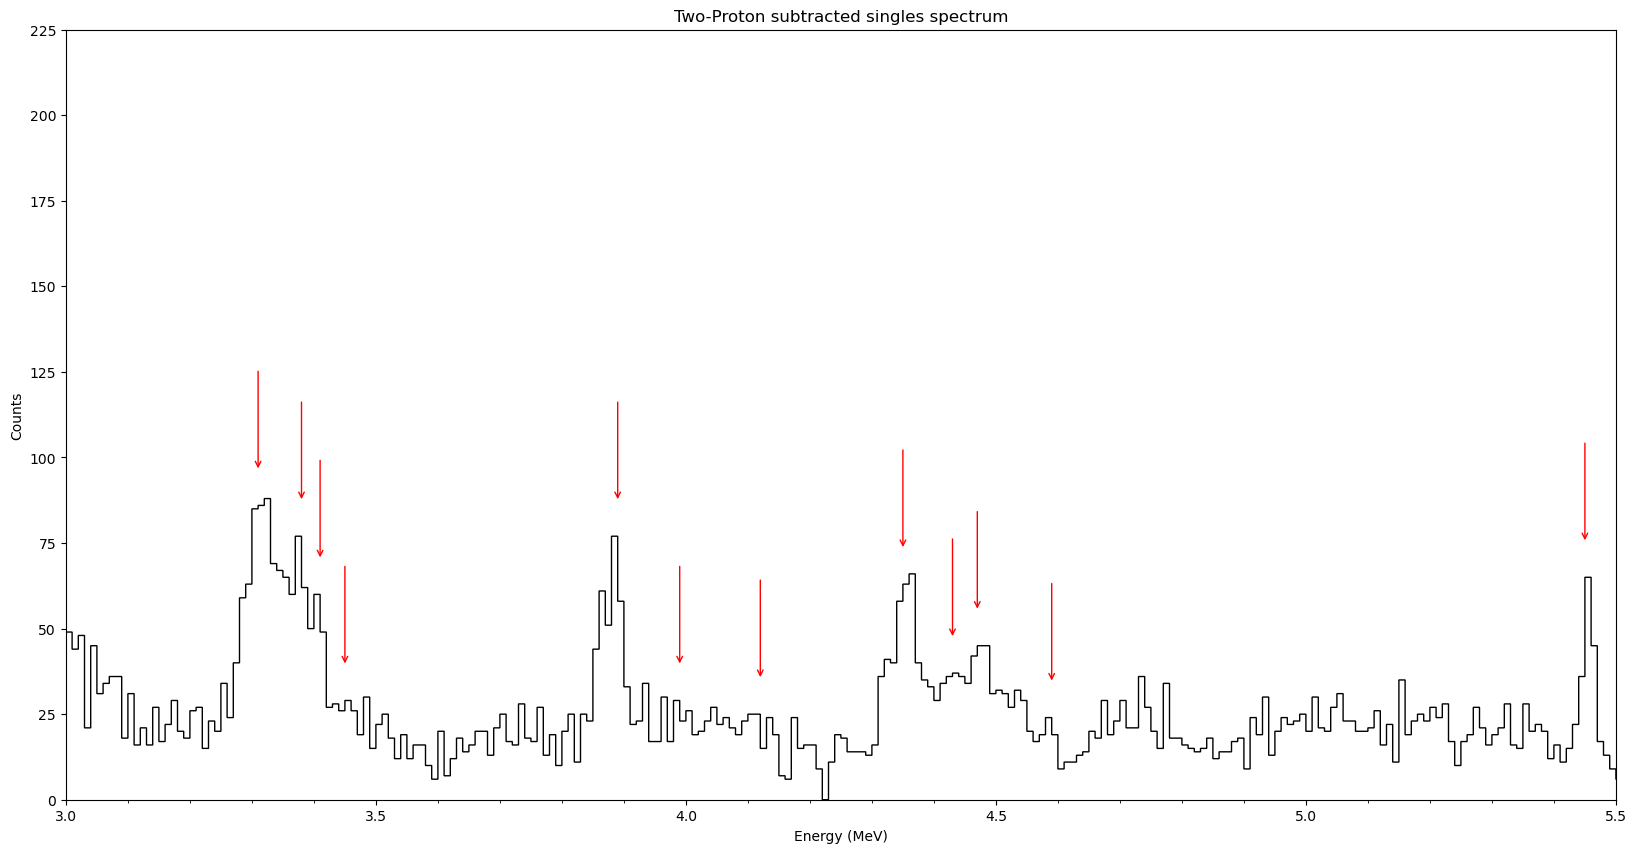

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(E/1e3, bins=bins, histtype='step', color='k')
#plt.hist(E2/1e3, bins=bins, histtype='step', color='k')
counts, _ = np.histogram(E/1e3, bins=bins)
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.title('Two-Proton subtracted singles spectrum')
#plt.legend()
#plt.yscale('log')
plt.ylim(0,225)
plt.xlim(3,5.5)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
one = draw_arrow_at_energy(ax, energy=3310, counts=counts, bins=bins)
two = draw_arrow_at_energy(ax, energy=3380, counts=counts, bins=bins)
three = draw_arrow_at_energy(ax, energy=3890, counts=counts, bins=bins)
four = draw_arrow_at_energy(ax, energy=4350, counts=counts, bins=bins)
five = draw_arrow_at_energy(ax, energy=4430, counts=counts, bins=bins)
six = draw_arrow_at_energy(ax, energy=4470, counts=counts, bins=bins)
eight = draw_arrow_at_energy(ax, energy=4590, counts=counts, bins=bins)
seven = draw_arrow_at_energy(ax, energy=5450, counts=counts, bins=bins)
nine = draw_arrow_at_energy(ax, energy=3450, counts=counts, bins=bins)
ten = draw_arrow_at_energy(ax, energy=3990, counts=counts, bins=bins)
eleven = draw_arrow_at_energy(ax, energy=4120, counts=counts, bins=bins)
twelve = draw_arrow_at_energy(ax, energy=3410, counts=counts, bins=bins)
#six = draw_arrow_at_energy(ax, energy=2250, counts=counts, bins=bins)
one,two,three,four,five,six,seven,eight, nine, ten, eleven